<a href="https://colab.research.google.com/github/alsh626626/CE888/blob/main/Assignment/Assignment1_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import csv
import urllib.request
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import requests
import re
import string
import math
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Number of train labels:       11916
Number of train text:         11916
Number of validation labels:  1324
Number of validation text:    1324
Number of test labels:        860
Number of test text:          860


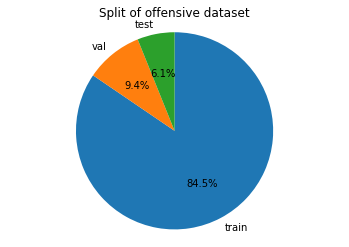

In [ ]:
# Load the data

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

# Experiment focus on hate, irony and offensive
# Both 3 tasks can be run on the same code by alternating the "task" parameter below
# Other tasks have not been tested and may occur errors
task='offensive'
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/test_labels.txt", allow_redirects=True)
open('test_labels.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/test_text.txt", allow_redirects=True)
open('test_text.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/train_labels.txt", allow_redirects=True)
open('train_labels.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/train_text.txt", allow_redirects=True)
open('train_text.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/val_labels.txt", allow_redirects=True)
open('val_labels.txt', 'wb').write(r.content)
r = requests.get(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/val_text.txt", allow_redirects=True)
open('val_text.txt', 'wb').write(r.content)

file = open('test_labels.txt')
test_labels = file.readlines()
file.close
file = open('test_text.txt')
test_text = file.readlines()
file.close
file = open('train_labels.txt')
train_labels = file.readlines()
file.close
file = open('train_text.txt')
train_text = file.readlines()
file.close
file = open('val_labels.txt')
val_labels = file.readlines()
file.close
file = open('val_text.txt')
val_text = file.readlines()
file.close

print("Number of train labels:      ", len(train_labels))
print("Number of train text:        ", len(train_text))
print("Number of validation labels: ", len(val_labels))
print("Number of validation text:   ", len(val_text))
print("Number of test labels:       ", len(test_labels))
print("Number of test text:         ", len(test_text))

labels = 'train', 'val', 'test'
sizes = [len(train_labels), len(val_labels), len(test_labels)]
plt.title(f"Split of {task} dataset")
plt.pie(sizes, labels=labels, autopct='%1.1f%%', counterclock=False, startangle=90)
plt.axis('equal')
plt.show()

In [ ]:
# download label mapping
import csv
import urllib.request
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]
print('Labels:', labels)

Labels: ['not-offensive', 'offensive']


In [ ]:
df = pd.DataFrame(data={'label': train_labels + val_labels + test_labels, 'text': train_text + val_text + test_text})
df

,label,text
0,0\n,@user Bono... who cares. Soon people will unde...
1,1\n,@user Eight years the republicans denied obama...
2,0\n,@user Get him some line help. He is gonna be j...
3,0\n,@user @user She is great. Hi Fiona! \n
4,1\n,@user She has become a parody unto herself? Sh...
...,...,...
14095,0\n,#CNN irrationally argues 4 legalising #abortio...
14096,0\n,@user @user @user @user @user @user @user @use...
14097,1\n,#Conservatives don’t care what you post..it’s ...
14098,0\n,#antifa #Resist.. Trump is trying to bring wor...


In [ ]:
# Cleaning the data
df['label'] = df['label'].apply(lambda x: re.sub('\n','', x))
df['text'] = df['text'].apply(lambda x: re.sub('\n','', x))
# Lowercase the words
df['cleaned'] = df['text'].apply(lambda x: x.lower())
# Remove digits and words containing digits
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))
# Remove Punctuations
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
# Remove extra spaces
df['cleaned'] = df['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['lemmatized']=df['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

df

,label,text,cleaned,lemmatized
0,0,@user Bono... who cares. Soon people will unde...,user bono who cares soon people will understan...,user bono care soon people understand gain fol...
1,1,@user Eight years the republicans denied obama...,user eight years the republicans denied obama’...,user year republicans deny obama pick breitbar...
2,0,@user Get him some line help. He is gonna be j...,user get him some line help he is gonna be jus...,user line help go to fine game go progress rea...
3,0,@user @user She is great. Hi Fiona!,user user she is great hi fiona,user user great hi fiona
4,1,@user She has become a parody unto herself? Sh...,user she has become a parody unto herself she ...,user parody unto certainly take heat anwell id...
...,...,...,...,...
14095,0,#CNN irrationally argues 4 legalising #abortio...,cnn irrationally argues legalising abortion in...,cnn irrationally argue legalise abortion irela...
14096,0,@user @user @user @user @user @user @user @use...,user user user user user user user user user u...,user user user user user user user user user u...
14097,1,#Conservatives don’t care what you post..it’s ...,conservatives don’t care what you postit’s use...,conservative care postit user propaganda
14098,0,#antifa #Resist.. Trump is trying to bring wor...,antifa resist trump is trying to bring world p...,antifa resist trump try bring world peace obst...


In [ ]:
# frequency distribution of raw text
from nltk.tokenize import word_tokenize
words = []
for row in df['text'][:len(train_text)].tolist():
  for w in word_tokenize(row):
    words.append(w.lower())
words_set = set(words)
counts = [(w, words.count(w)) for w in words_set]

# ranking
import scipy.stats as ss
from nltk.corpus import wordnet
amb = [(w, c, len(wordnet.synsets(w))) for (w, c) in counts if len(wordnet.synsets(w)) > 0]
amb_p_rank = ss.rankdata([p for (w, c, p) in amb])
amb_c_rank = ss.rankdata([c for (w, c, p) in amb])

correlation coefficient: -0.9952104277426039


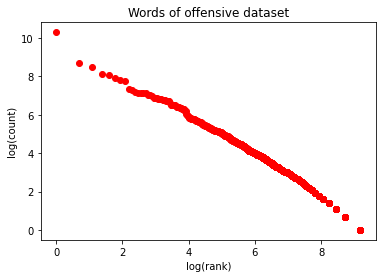

In [ ]:
max = np.max(amb_c_rank)
rev = [max-r+1 for r in amb_c_rank]
plt.title(f"Words of {task} dataset")
plt.plot([math.log(c) for c in rev], [math.log(c) for (w, c, p) in amb], 'ro')
plt.xlabel('log(rank)')
plt.ylabel('log(count)')

# correlation coefficient
print("correlation coefficient:", np.corrcoef([math.log(c) for c in rev], [math.log(c) for (w, c, p) in amb])[0][1])

In [ ]:
df_grouped=df[['label','lemmatized']][:len(train_text)].groupby(by='label').agg(lambda x:' '.join(x))

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer='word')
data = cv.fit_transform(df_grouped['lemmatized'])
df_grouped_vector = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_grouped_vector.index = df_grouped.index

# Transposing DataFrame
df_grouped_vector = df_grouped_vector.transpose()

In [ ]:
for index,label in enumerate(df_grouped_vector.columns):
  print("label:", labels[index])
  print(df_grouped_vector[label].sort_values(ascending=False)[:20], "\n")

label: not-offensive
user            21935
liberal           892
gun               886
not               875
antifa            760
control           704
conservative      672
maga              647
like              607
people            495
know              460
think             437
good              393
trump             345
right             340
amp               336
go                334
want              322
need              320
say               284
Name: 0, dtype: int64 

label: offensive
user            8006
liberal          569
gun              493
not              474
like             427
control          402
people           339
shit             303
antifa           278
know             275
maga             271
conservative     252
amp              245
think            235
trump            233
fuck             197
go               195
say              180
want             166
need             161
Name: 1, dtype: int64 



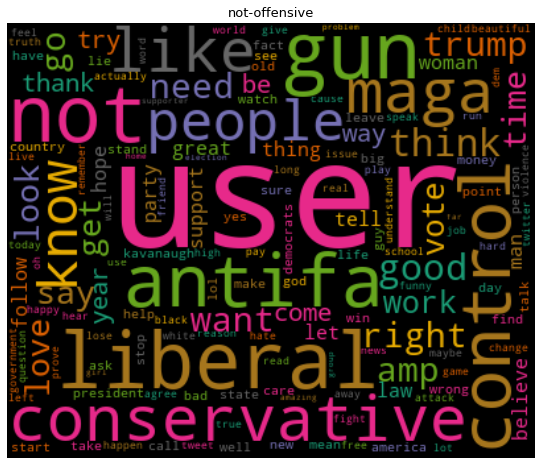

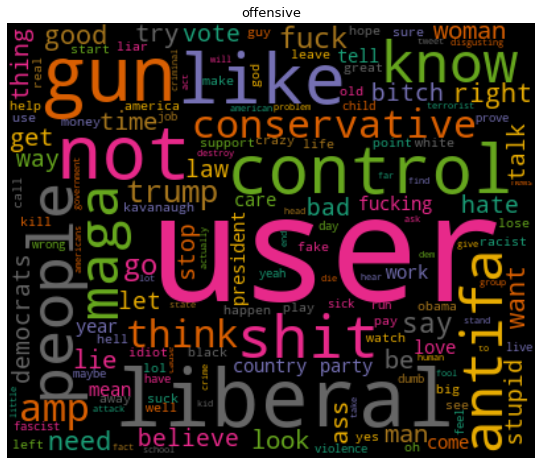

In [ ]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()

# Plotting word cloud for each label
for index,label in enumerate(df_grouped_vector.columns):
  generate_wordcloud(df_grouped_vector[label].sort_values(ascending=False),labels[index])

In [ ]:
df['lemmatized'] = df['lemmatized'].astype(str)
train_text_list = df['lemmatized'][:len(train_text)].tolist()
val_text_list = df['lemmatized'][len(train_text):len(train_text) + len(val_text)].tolist()
test_text_list = df['lemmatized'][len(train_text) + len(val_text):].tolist()

df['label'] = df['label'].astype(int)
train_label_list = df['label'][:len(train_text)].tolist()
val_label_list = df['label'][len(train_text):len(train_text) + len(val_text)].tolist()
test_label_list = df['label'][len(train_text) + len(val_text):].tolist()

# only training set will be used to obtain features
from nltk.tokenize import word_tokenize
all_words = []
for doc in train_text_list:
    for w in word_tokenize(doc):
        all_words.append(w.lower())
print ("Total number of words: ", len(list(all_words)))

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [w for w in all_words if not w in stop_words]
print ("Total number of filtered words: ", len(list(filtered_words)))

filtered_words_FD = nltk.FreqDist(filtered_words)
print(filtered_words_FD)
filtered_words_list = list(filtered_words_FD.items())
filtered_words_list.sort(key = lambda x: x[1], reverse = True)

Total number of words:  143796
Total number of filtered words:  140974
<FreqDist with 15657 samples and 140974 outcomes>


In [ ]:
def find_features(document):
    document = word_tokenize(document)
    words = set(document)
    features = {}
    for w in word_features:
        # features[w] = (w in words)
        # compute frequency
        features[w] = document.count(w)
    return features

In [ ]:
# Creating feature vector
# most frequently 3000 word is selected as the features
word_features = [i[0] for i in filtered_words_list[:3000]]

train_set = list(zip([find_features(rev) for rev in train_text_list], [label for label in train_label_list]))
val_set = list(zip([find_features(rev) for rev in val_text_list], [label for label in val_label_list]))
test_set = list(zip([find_features(rev) for rev in test_text_list], [label for label in test_label_list]))

Naive Bayes:
Accuracy Score: 0.7779069767441861


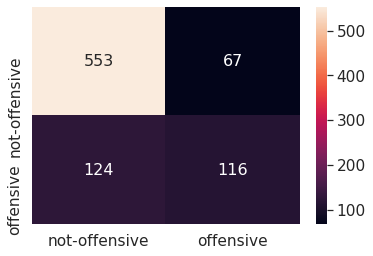

In [ ]:
# Naive Bayes Classifier is used as the classification model
classifier_1 = nltk.NaiveBayesClassifier.train(train_set)
test_set_content = [i[0] for i in test_set]
golden_label = [i[1] for i in test_set]
tested_label = classifier_1.classify_many(test_set_content)

print("Naive Bayes:")
accuracy = metrics.accuracy_score(golden_label, tested_label)
print('Accuracy Score:', accuracy)
cm = confusion_matrix(golden_label, tested_label)
df_cm = pd.DataFrame(cm, labels, labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Support Vector Machine:
Accuracy Score: 0.7790697674418605


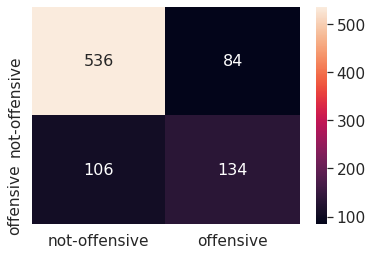

In [ ]:
# Support Vector Machine is used as the classification model
from sklearn.svm import LinearSVC
from nltk.classify.scikitlearn import SklearnClassifier
classifier_2 = SklearnClassifier(LinearSVC()).train(train_set)
test_set_content = [i[0] for i in test_set]
golden_label = [i[1] for i in test_set]
tested_label = classifier_2.classify_many(test_set_content)

print("Support Vector Machine:")
accuracy = metrics.accuracy_score(golden_label, tested_label)
print('Accuracy Score:', accuracy)
cm = confusion_matrix(golden_label, tested_label)
df_cm = pd.DataFrame(cm, labels, labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.show()

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = [
    ]
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


RoBERTa:
Accuracy Score: 0.8558139534883721


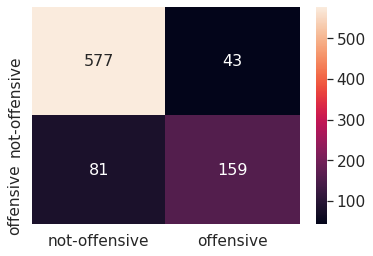

In [ ]:
# RoBERTa is used as the classification model
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)

golden_label = [i[1] for i in test_set]
tested_label = []
for i in range(len(test_text)):
  text = test_text[i]
  text = preprocess(text)
  encoded_input = tokenizer(text, return_tensors='pt')
  output = model(**encoded_input)
  scores = output[0][0].detach().numpy()
  scores = softmax(scores)
  tested_label.append(np.argmax(scores))

print("RoBERTa:")
accuracy = metrics.accuracy_score(golden_label, tested_label)
print('Accuracy Score:', accuracy)
cm = confusion_matrix(golden_label, tested_label)
df_cm = pd.DataFrame(cm, labels, labels)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt="d", annot_kws={"size": 16}) # font size
plt.show()